# Stationarity Example
### Produces Figure 3

Here we test the stationarity of a local field potential from the hippocampus. We find that for time frames of less than one second, the LFP may be stationary. On timescales longer than this, it is non-stationary.

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import loadmat
from statsmodels.tsa.stattools import adfuller

### Load data

In [2]:
x = loadmat('JBCA1ppDG_1-240615-SOR-open_field_egf2_ex.mat')
x = x['egf']
x = x.reshape(x.shape[0])
Fs = 4800

### Downsample
Here we downsample by the given $\textit{factor}$. 

In [3]:
factor = 4
Fs = Fs/factor
x = scipy.signal.decimate(x, q=factor, zero_phase=True)

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:3424: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


### Test stationarity
We select $\textit{n_starts}$ random positions in the LFP signal. For each, we have $\textit{n_lens}$ signal lengths from $\textit{min_l}$ to $\textit{max_l}$. We loop through all start positions and all signal lengths, computing the stationarity score via the augmented Dickey-Fuller test.

In [4]:
n_starts = 30
n_lens = 100
min_l = 0.01
max_l = 2.
lens = np.linspace(min_l, max_l, n_lens)
starts = np.random.randint(int(len(x)-max_l*Fs), size=(n_starts,))
adf_test = np.empty(shape=(n_starts, n_lens, 2))
for s_i, start in enumerate(starts):
    for l_i, l in enumerate(lens):
        stop = int(start + l*Fs)
        y = x[start:stop] - np.mean(x[start:stop])
        a = adfuller(y)
        adf_test[s_i, l_i, 0] = a[0]
        adf_test[s_i, l_i, 1] = a[1]

adf_avg = np.mean(adf_test, axis=0)
adf_std = np.std(adf_test, axis=0)

### Plot

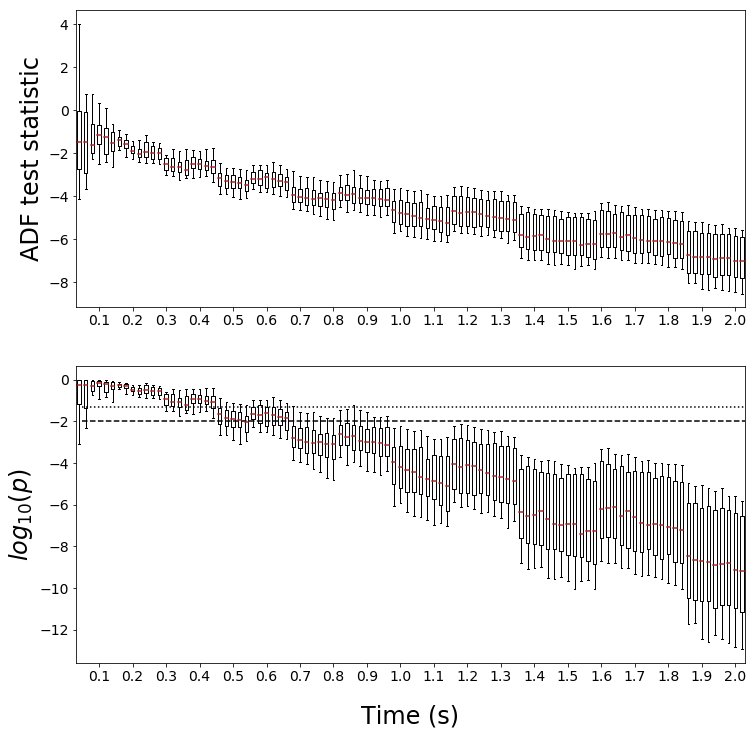

In [5]:
eps = 10**-20 # add this when taking logarithm to avoid zero values

inds = np.linspace(4, n_lens-1, 20, dtype=int)
tks = np.round(lens[inds], 1)

fig, ax = plt.subplots(figsize=(12,12))

plt.subplot(211)
bp = plt.boxplot(adf_test[:,:,0], whis=[5,95], showfliers=False)
plt.ylabel('ADF test statistic', fontsize=24)
plt.xticks(inds, tks, fontsize=14)
plt.yticks(fontsize=14)

for median in bp['medians']:
    median.set(color='firebrick', linewidth=1.5)

plt.subplot(212)
bp = plt.boxplot(np.log10(adf_test[:,:,1] + eps), whis=[5,95], showfliers=False)
plt.axhline(np.log10(0.05), lens[0], lens[n_lens-1], color='k', linestyle=':')
plt.axhline(np.log10(0.01), lens[0], lens[n_lens-1], color='k', linestyle='--')
plt.ylabel('$log_{10} (p)$', fontsize=24)
plt.xticks(inds, tks, fontsize=14)
plt.yticks(fontsize=14)

for median in bp['medians']:
    median.set(color='firebrick', linewidth=1.5)


plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('eeg_nonstationary_ADF_test.pdf')
plt.show()